<img src="flopylogo.png" style="float: left">

# Problem P4.3 Hubbertville Areal Model

In Problem P4.3 from page 172-174 in Anderson, Woessner and Hunt (2015), we are asked to construct an areal 2D model to assess impacts of pumping.  The town of Hubbertville is planning to expand its water supply by constructing a pumping well in an unconfined gravel aquifer (Fig. P4.3). The well is designed to pump constantly at a rate of 20,000 m3/day. Well construction was halted by the State Fish and Game Service who manage the Green Swamp Conservation area. The agency claimed that pumping would “significantly reduce” groundwater discharge to the swamp and damage waterfowl habitat. The town claimed the fully penetrating river boundary to the north and the groundwater divide located near the center of the valley would prevent any change in flow to the swamp.

## Part a.
Construct a 2D areal steady-state model of the aquifer between the river and swamp for conditions prior to pumping using the information in Fig. P4.3. Represent the river and swamp boundaries as constant head boundaries with head set at 1000 m. The side boundaries are no-flow boundaries. Justify this assignment of boundary conditions. Use a constant nodal spacing of 500 m. Run the model and produce a contour map of heads. Draw the water-table profile in a north-south cross-section and label the simulated groundwater divide between the river and the swamp. Compute the discharge to Green Swamp.

In this notebook, we will work through the problem using MODFLOW and the Python tool set Flopy. Notice how much code is reused from P4.1 because the variable names remained the same.

<img src="P4.3_figure.tiff" style="float: center">

Below is an iPython Notebook that builds a Python MODFLOW model for this problem and plots results. See the Github wiki associated with this Chapter for information on one suggested installation and setup configuration for Python and iPython Notebook.

[Acknowledgements: This tutorial is modeled after example iPython Notebooks developed by Chris Langevin and Joe Hughes for the USGS Spring 2015 Python Training course GW1774]

##Flopy Tutorial 1: Creating the Model
In this example, we will create a simple groundwater flow model by following the tutorial included on the Flopy website.  We will make a few small changes  so that the tutorial works with our file structure.

Visit the tutorial website [here](http://modflowpy.github.io/flopydoc/tutorial1.html "tutorial").

###Setup the Notebook Environment and Import Flopy
Load a few standard libraries, and then load flopy.

In [1]:
%matplotlib inline
import sys
import os
import shutil
import numpy as np
from subprocess import check_output

# Import flopy
import flopy

###Setup a New Directory and Change Paths
For this tutorial, we will work in a new subdirectory underneath the directory where the notebook is located. We can use some fancy Python tools to help us manage the directory creation. Note that if you encounter path problems with this workbook, you can stop and then restart the kernel and the paths will be reset.

In [2]:
# Set the name of the path to the model working directory
dirname = "P4-3_Hubbertville"
datapath = os.getcwd()
modelpath = os.path.join(datapath, dirname)
print 'Name of model path: ', modelpath

# Now let's check if this directory exists.  If not, then we will create it.
if os.path.exists(modelpath):
    print 'Model working directory already exists.'
else:
    print 'Creating model working directory.'
    os.mkdir(modelpath)

Name of model path:  /Users/rjhunt1/GitHub/Chapter_4_problems-1/P4-3_Hubbertville
Creating model working directory.


###Define the Model Extent, Grid Resolution, and Characteristics
It is normally good practice to group things that you might want to change into a single code block.  This makes it easier to make changes and rerun the code.

In [3]:
# model domain and grid definition
# for clarity, user entered variables are all caps; python syntax are lower case or mixed case
# In a contrast to P4.1 and P4.2, this is an areal 2D model
LX = 4500.
LY = 11000.   # note that there is an added 500m on the top and bottom to represent the boundary conditions,that leaves an aqufier lenght of 10000 m  
ZTOP = 1030.  # the system is unconfined so set the top above land surface so that the water table never > layer top
ZBOT = 980.
NLAY = 1
NROW = 22
NCOL = 9
DELR = LX / NCOL  # recall that MODFLOW convention is DELR is along a row, thus has items = NCOL; see page XXX in AW&H (2015)
DELC = LY / NROW  # recall that MODFLOW convention is DELC is along a column, thus has items = NROW; see page XXX in AW&H (2015)
DELV = (ZTOP - ZBOT) / NLAY
BOTM = np.linspace(ZTOP, ZBOT, NLAY + 1)
HK = 50.
VKA = 1.
RCH = 0.001
WELLQ = 0.   #recall MODFLOW convention, negative means pumped out of the model domain (=aquifer)
print "DELR =", DELR, "  DELC =", DELC, '  DELV =', DELV
print "BOTM =", BOTM
print "Recharge =", RCH 
print "Pumping well rate =", WELLQ


DELR = 500.0   DELC = 500.0   DELV = 50.0
BOTM = [ 1030.   980.]
Recharge = 0.001
Pumping well rate = 0.0


###Create the MODFLOW Model Object
Create a flopy MODFLOW object: [flopy.modflow.Modflow](http://modflowpy.github.io/flopydoc/mf.html).

In [4]:
# Assign name and create modflow model object
modelname = 'P4-3'
#exe_name = os.path.join(datapath, 'mf2005.exe') # for Windows OS
exe_name = os.path.join(datapath, 'mf2005')     # for Mac OS
print 'Model executable: ', exe_name
MF = flopy.modflow.Modflow(modelname, exe_name=exe_name, model_ws=modelpath)

Model executable:  /Users/rjhunt1/GitHub/Chapter_4_problems-1/mf2005


###Discretization Package
Create a flopy discretization package object: [flopy.modflow.ModflowDis](http://modflowpy.github.io/flopydoc/mfdis.html).

In [5]:
# Create the discretization object
TOP = ZTOP * np.ones((NROW, NCOL),dtype=np.float)

In [6]:
DIS_PACKAGE = flopy.modflow.ModflowDis(MF, NLAY, NROW, NCOL, delr=DELR, delc=DELC,
                               top=TOP, botm=BOTM[1:], laycbd=0)
# print DIS_PACKAGE  #uncomment this on far left to see information about the flopy object

###Basic Package
Create a flopy basic package object: [flopy.modflow.ModflowBas](http://modflowpy.github.io/flopydoc/mfbas.html).

In [7]:
# Variables for the BAS package
IBOUND = np.ones((NLAY, NROW, NCOL), dtype=np.int32)  # all nodes are active (IBOUND = 1)

# make the top of the profile specified head by setting the IBOUND = -1
IBOUND[:, 0, :] = -1  #don't forget arrays are zero-based!
IBOUND[:, -1, :] = -1  #-1 is Python for last in array
print IBOUND

[[[-1 -1 -1 -1 -1 -1 -1 -1 -1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [-1 -1 -1 -1 -1 -1 -1 -1 -1]]]


In [8]:
STRT = 1015 * np.ones((NLAY, NROW, NCOL), dtype=np.float32)  # set starting head to 1010 m through out model domain
STRT[:, 0, :] = 1000.       # river stage for setting constant head
STRT[:, -1, :] = 1000.     # wetland stage for setting constant head
print STRT

[[[ 1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.]
  [ 1015.  1015.  1015.  1015.  1015.  1015.  1015.  1015.  1015.]
  [ 1015.  1015.  1015.  1015.  1015.  1015.  1015.  1015.  1015.]
  [ 1015.  1015.  1015.  1015.  1015.  1015.  1015.  1015.  1015.]
  [ 1015.  1015.  1015.  1015.  1015.  1015.  1015.  1015.  1015.]
  [ 1015.  1015.  1015.  1015.  1015.  1015.  1015.  1015.  1015.]
  [ 1015.  1015.  1015.  1015.  1015.  1015.  1015.  1015.  1015.]
  [ 1015.  1015.  1015.  1015.  1015.  1015.  1015.  1015.  1015.]
  [ 1015.  1015.  1015.  1015.  1015.  1015.  1015.  1015.  1015.]
  [ 1015.  1015.  1015.  1015.  1015.  1015.  1015.  1015.  1015.]
  [ 1015.  1015.  1015.  1015.  1015.  1015.  1015.  1015.  1015.]
  [ 1015.  1015.  1015.  1015.  1015.  1015.  1015.  1015.  1015.]
  [ 1015.  1015.  1015.  1015.  1015.  1015.  1015.  1015.  1015.]
  [ 1015.  1015.  1015.  1015.  1015.  1015.  1015.  1015.  1015.]
  [ 1015.  1015.  1015.  1015.  1015.  1015.  1015.  1015.  10

In [9]:
BAS_PACKAGE = flopy.modflow.ModflowBas(MF, ibound=IBOUND, strt=STRT)
# print BAS_PACKAGE  # uncomment this at far left to see the information about the flopy BAS object

###Layer Property Flow Package
Create a flopy layer property flow package object: [flopy.modflow.ModflowLpf](http://modflowpy.github.io/flopydoc/mflpf.html).

In [10]:
LPF_PACKAGE = flopy.modflow.ModflowLpf(MF, laytyp=1, hk=HK, vka=VKA)  # we defined the K and anisotropy at top of file
# print LPF_PACKAGE  # uncomment this at far left to see the information about the flopy LPF object

###Well Package
Create a flopy output control object: [flopy.modflow.ModflowWel](http://modflowpy.github.io/flopydoc/mfwel.html).

In [11]:
WEL_PACKAGE = flopy.modflow.ModflowWel(MF, stress_period_data=[0,6,4,WELLQ])  # remember python 0 index, layer 0 = layer 1 in MF
#print WEL_PACKAGE  # uncomment this at far left to see the information about the flopy WEL object

###Output Control
Create a flopy output control object: [flopy.modflow.ModflowOc](http://modflowpy.github.io/flopydoc/mfoc.html).

In [12]:
OC_PACKAGE = flopy.modflow.ModflowOc(MF)   # we'll use the defaults for the model output
# print OC_PACKAGE  # uncomment this at far left to see the information about the flopy OC object

###Preconditioned Conjugate Gradient Solver
Create a flopy pcg package object: [flopy.modflow.ModflowPcg](http://modflowpy.github.io/flopydoc/mfpcg.html).

In [13]:
PCG_PACKAGE = flopy.modflow.ModflowPcg(MF, mxiter=500, iter1=100, hclose=1e-04, rclose=1e-03, relax=0.98, damp=0.5) 
# print PCG_PACKAGE  # uncomment this at far left to see the information about the flopy PCG object

###Recharge Package
Create a flopy pcg package object: [flopy.modflow.ModflowRch](http://modflowpy.github.io/flopydoc/mfrch.html).

In [14]:
RCH_PACKAGE = flopy.modflow.ModflowRch(MF, rech=RCH)
# print RCH_PACKAGE  # uncomment this at far left to see the information about the flopy RCH object

##Flopy Tutorial 1: Writing the MODFLOW Input Files
Before we create the model input datasets, we can do some directory cleanup to make sure that we don't accidently use old files.

In [15]:
#Before writing input, destroy all files in folder to prevent reusing old files
#Here's the working directory
print modelpath
#Here's what's currently in the working directory
modelfiles = os.listdir(modelpath)
print modelfiles

/Users/rjhunt1/GitHub/Chapter_4_problems-1/P4-3_Hubbertville
[]


In [16]:
#delete these files to prevent us from reading old results
modelfiles = os.listdir(modelpath)
for filename in modelfiles:
    f = os.path.join(modelpath, filename)
    if modelname in f:
        try:
            os.remove(f)
            print 'Deleted: ', filename
        except:
            print 'Unable to delete: ', filename

In [17]:
#Now write the model input files
MF.write_input()

Yup.  It's that simple, the model datasets are written using a single command (mf.write_input).

Check in the model working directory and verify that the input files have been created.  Or if you might just add another cell, right after this one, that prints a list of all the files in our model directory.  The path we are working in is returned from this next block.

In [18]:
# return current working directory
print "You can check the newly created files in", modelpath


You can check the newly created files in /Users/rjhunt1/GitHub/Chapter_4_problems-1/P4-3_Hubbertville


##Flopy Tutorial 1: Running the Model

Flopy has several methods attached to the model object that can be used to run the model.  They are run_model, run_model2, and run_model3.  Here we use run_model3, which will write output to the notebook.

In [19]:
silent = False  #Print model output to screen?
pause = False   #Require user to hit enter? Doesn't mean much in Ipython notebook
report = True   #Store the output from the model in buff
success, buff = MF.run_model(silent=silent, pause=pause, report=report)

FloPy is using the following executable to run the model: /Users/rjhunt1/GitHub/Chapter_4_problems-1/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.11.00 8/8/2013                        

 Using NAME file: P4-3.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2015/04/24 13:47:49

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2015/04/24 13:47:49
 Elapsed run time:  0.011 Seconds

  Normal termination of simulation


##Flopy Tutorial 1: Post Processing the Results
To read heads from the MODFLOW binary output file, we can use the [flopy.utils.binaryfile](http://modflowpy.github.io/flopydoc/binaryfile.html) module. Specifically, we can use the HeadFile object from that module to extract head data arrays. 

In [20]:
#imports for plotting and reading the MODFLOW binary output file
import matplotlib.pyplot as plt
import flopy.utils.binaryfile as bf

#Create the headfile object and grab the results for last time.
headfile = os.path.join(modelpath, modelname + '.hds')
headfileobj = bf.HeadFile(headfile)

#Get a list of times that are contained in the model
times = headfileobj.get_times()
print 'Headfile (' + modelname + '.hds' + ') contains the following list of times: ', times

Headfile (P4-3.hds) contains the following list of times:  [1.0]


In [21]:
#Get a numpy array of heads for totim = 1.0
#The get_data method will extract head data from the binary file.
HEAD = headfileobj.get_data(totim=1.0)

#Print statistics on the head
print 'Head statistics'
print '  min: ', HEAD.min()
print '  max: ', HEAD.max()
print '  std: ', HEAD.std()

Head statistics
  min:  1000.0
  max:  1010.83
  std:  3.47007


Contour Levels:  [ 1000.   1000.5  1001.   1001.5  1002.   1002.5  1003.   1003.5  1004.
  1004.5  1005.   1005.5  1006.   1006.5  1007.   1007.5  1008.   1008.5
  1009.   1009.5  1010.   1010.5]
Extent of domain:  (250.0, 4250.0, 250.0, 10750.0)


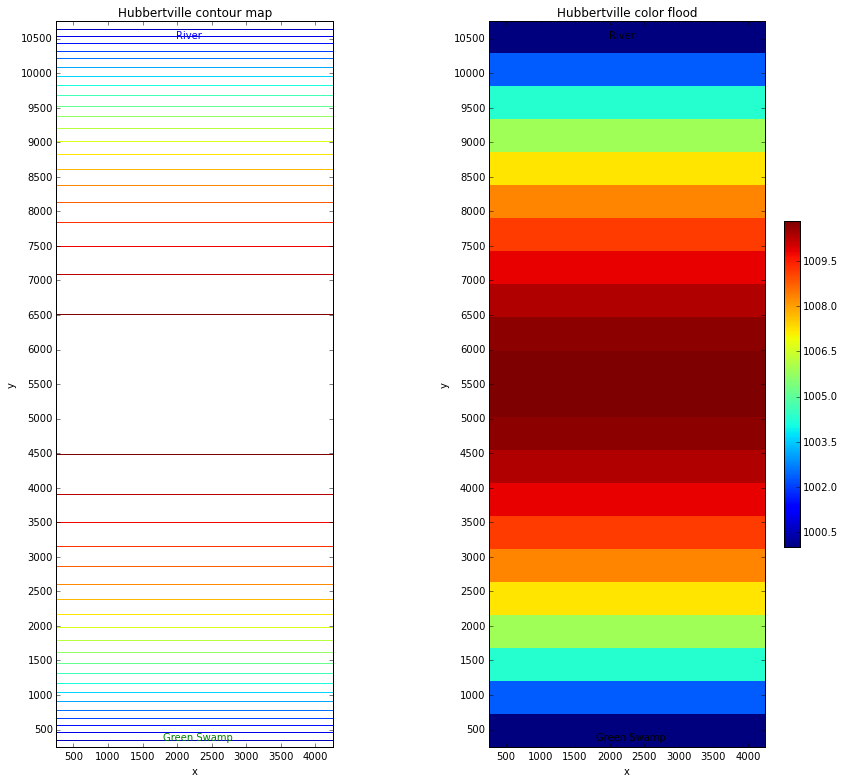

In [22]:
#Create a contour plot of heads
FIG = plt.figure(figsize=(15,13))

#setup contour levels and plot extent
LEVELS = np.arange(1000., 1011., 0.5)
EXTENT = (DELR/2., LX - DELR/2., DELC/2., LY - DELC/2.)
print 'Contour Levels: ', LEVELS
print 'Extent of domain: ', EXTENT

#Make a contour plot on the first axis
AX1 = FIG.add_subplot(1, 2, 1, aspect='equal')
AX1.set_xlabel("x")
AX1.set_ylabel("y")
YTICKS = np.arange(0, 11000, 500)
AX1.set_yticks(YTICKS)
AX1.set_title("Hubbertville contour map")
AX1.text(2000, 10500, r"River", fontsize=10, color="blue")
AX1.text(1800, 340, r"Green Swamp", fontsize=10, color="green")
AX1.contour(np.flipud(HEAD[0, :, :]), levels=LEVELS, extent=EXTENT)

#Make a color flood on the second axis
AX2 = FIG.add_subplot(1, 2, 2, aspect='equal')
AX2.set_xlabel("x")
AX2.set_ylabel("y")
AX2.set_yticks(YTICKS)
AX2.set_title("Hubbertville color flood")
AX2.text(2000, 10500, r"River", fontsize=10, color="black")
AX2.text(1800, 340, r"Green Swamp", fontsize=10, color="black")
cax = AX2.imshow(HEAD[0, :, :], extent=EXTENT, interpolation='nearest')
cbar = FIG.colorbar(cax, orientation='vertical', shrink=0.45)


Look at the bottom of the MODFLOW output file (ending with a *.list) and note the water balance reported. 

In [23]:
#look at the head in column = 4 from headobj, and then plot it
#print HEAD along a column; COL is a variable that allows us to change this easily
COL = 4
print HEAD[0,:,COL]

[ 1000.          1002.36767578  1004.29956055  1005.8949585   1007.21380615
  1008.29510498  1009.16546631  1009.84344482  1010.34191895  1010.66973877
  1010.83233643  1010.83233643  1010.66973877  1010.34191895  1009.84344482
  1009.16546631  1008.29510498  1007.21380615  1005.8949585   1004.29956055
  1002.36767578  1000.        ]


In [24]:
# we see this is what we want, but is flipped because MODFLOW's array does not = Python, so we reverse the order (flip them) and call it 
Y = np.flipud(HEAD[0,:,COL])
print Y

[ 1000.          1002.36767578  1004.29956055  1005.8949585   1007.21380615
  1008.29510498  1009.16546631  1009.84344482  1010.34191895  1010.66973877
  1010.83233643  1010.83233643  1010.66973877  1010.34191895  1009.84344482
  1009.16546631  1008.29510498  1007.21380615  1005.8949585   1004.29956055
  1002.36767578  1000.        ]


In [25]:
#for our cross section create X-coordinates to match with heads
XCOORD = np.arange(0, 11000, 500) + 250
print XCOORD

[  250   750  1250  1750  2250  2750  3250  3750  4250  4750  5250  5750
  6250  6750  7250  7750  8250  8750  9250  9750 10250 10750]


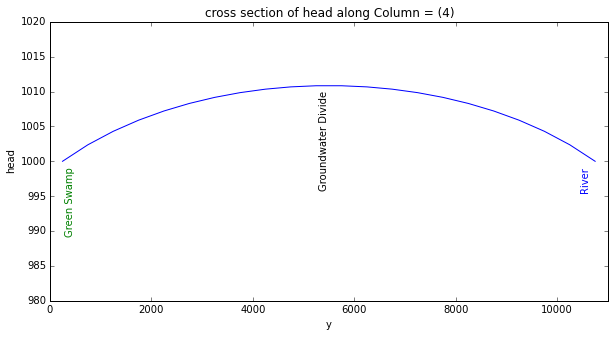

In [26]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)
TITLE =  'cross section of head along Column = ({0})'.format(COL)
ax.set_title(TITLE)
ax.set_xlabel('y')
ax.set_ylabel('head')
ax.set_xlim(0, 11000.)
ax.set_ylim(980.,1020.)
ax.text(10480, 998, r"River", fontsize=10, color="blue",rotation='vertical')
ax.text(300, 998, r"Green Swamp", fontsize=10, color="green",rotation='vertical')
ax.text(5300,1009., r"Groundwater Divide", fontsize=10, color="black",rotation='vertical')
ax.plot(XCOORD, Y)

In [27]:
#calculate the flux to Green Swamp
HEAD_ADJACENT_CELLS = HEAD[0,-2,:]
print "heads in cells next to Green Swamp =", HEAD_ADJACENT_CELLS
FLUX_TO_SWAMP = 0
THICK = (HEAD[0,-2,5]+1000.)/2 - ZBOT   #the thickness is approximated using the average saturated thickness
for NODEHEAD in HEAD_ADJACENT_CELLS:
    NODEFLUX = (HK * ((NODEHEAD-1000.)/(DELC)) * (DELR * THICK)) # Q = KIA
    FLUX_TO_SWAMP += NODEFLUX
    print 'gradient =', (NODEHEAD-1000)/(DELC), '  Kh =', HK, '  thickness=', THICK, ' Grid spacing =', DELC, ' Node flux =', NODEFLUX
print "Total Flux to Swamp =", FLUX_TO_SWAMP, "cubic meters per day"

heads in cells next to Green Swamp = [ 1002.36767578  1002.36767578  1002.36767578  1002.36767578  1002.36767578
  1002.36767578  1002.36767578  1002.36767578  1002.36767578]
gradient = 0.0047353515625   Kh = 50.0   thickness= 21.1838378906  Grid spacing = 500.0  Node flux = 2507.82299638
gradient = 0.0047353515625   Kh = 50.0   thickness= 21.1838378906  Grid spacing = 500.0  Node flux = 2507.82299638
gradient = 0.0047353515625   Kh = 50.0   thickness= 21.1838378906  Grid spacing = 500.0  Node flux = 2507.82299638
gradient = 0.0047353515625   Kh = 50.0   thickness= 21.1838378906  Grid spacing = 500.0  Node flux = 2507.82299638
gradient = 0.0047353515625   Kh = 50.0   thickness= 21.1838378906  Grid spacing = 500.0  Node flux = 2507.82299638
gradient = 0.0047353515625   Kh = 50.0   thickness= 21.1838378906  Grid spacing = 500.0  Node flux = 2507.82299638
gradient = 0.0047353515625   Kh = 50.0   thickness= 21.1838378906  Grid spacing = 500.0  Node flux = 2507.82299638
gradient = 0.0047353

In [28]:
#calculate the flux to River
HEAD_ADJACENT_CELLS = HEAD[0,1,:]
print "heads in cells next to River =", HEAD_ADJACENT_CELLS
FLUX_TO_RIVER = 0
THICK = (HEAD[0,-2,5]+1000.)/2 - ZBOT   #the thickness is approximated using the average saturated thickness
for NODEHEAD in HEAD_ADJACENT_CELLS:
    NODEFLUX = (HK * (NODEHEAD-1000.)/(DELC) * DELR * THICK) # Q = KIA
    FLUX_TO_RIVER += NODEFLUX
    print 'gradient =', (NODEHEAD-1000)/(DELC), '  Kh =', HK, '  thickness=', THICK, ' Grid spacing =', DELC, ' Node flux =', NODEFLUX
print "Total Flux to River =", FLUX_TO_RIVER, "cubic meters per day"

heads in cells next to River = [ 1002.36767578  1002.36767578  1002.36767578  1002.36767578  1002.36767578
  1002.36767578  1002.36767578  1002.36767578  1002.36767578]
gradient = 0.0047353515625   Kh = 50.0   thickness= 21.1838378906  Grid spacing = 500.0  Node flux = 2507.82299638
gradient = 0.0047353515625   Kh = 50.0   thickness= 21.1838378906  Grid spacing = 500.0  Node flux = 2507.82299638
gradient = 0.0047353515625   Kh = 50.0   thickness= 21.1838378906  Grid spacing = 500.0  Node flux = 2507.82299638
gradient = 0.0047353515625   Kh = 50.0   thickness= 21.1838378906  Grid spacing = 500.0  Node flux = 2507.82299638
gradient = 0.0047353515625   Kh = 50.0   thickness= 21.1838378906  Grid spacing = 500.0  Node flux = 2507.82299638
gradient = 0.0047353515625   Kh = 50.0   thickness= 21.1838378906  Grid spacing = 500.0  Node flux = 2507.82299638
gradient = 0.0047353515625   Kh = 50.0   thickness= 21.1838378906  Grid spacing = 500.0  Node flux = 2507.82299638
gradient = 0.0047353515625

In [29]:
print 'Flux to Green Swamp =', FLUX_TO_SWAMP, '  Flux to River =', FLUX_TO_RIVER
BCFLUX = FLUX_TO_SWAMP + FLUX_TO_RIVER
Q = WELLQ * -1
print 'Flux to BCs =', BCFLUX,', Well pumping =', Q,', Total Vol Out =', BCFLUX+Q, 'cubic meters per day'

Flux to Green Swamp = 22570.4069674   Flux to River = 22570.4069674
Flux to BCs = 45140.8139348 , Well pumping = -0.0 , Total Vol Out = 45140.8139348 cubic meters per day


##Testing your Skills

1.  Does the total volumetric flux out equal that reported in the MODFLOW list file?

2.  Experiment with horizontal grid resolution, well location, recharge, pumping rate, and aquifer characteristics.  Rerun the model and post process to evaluate the effects.

#P4.3 Part b.

Using the steady-state heads derived in (a), locate the groundwater divide in the central portion of the valley. Run the model using first a no-flow boundary and then a specified head boundary at the location of the groundwater divide.
Compare results with those in part (a). Compute the discharge to Green Swamp under each representation. What is the effect of assigning an internal boundary on the results?

In [30]:
# let's print out some heads by row to see which has the highest head (=the gw divide); don't forget arrays are zero-based!
print HEAD[0,9,:]

[ 1010.66973877  1010.66973877  1010.66973877  1010.66973877  1010.66973877
  1010.66973877  1010.66973877  1010.66973877  1010.66973877]


In [31]:
print HEAD[0,10,:]

[ 1010.83233643  1010.83233643  1010.83233643  1010.83233643  1010.83233643
  1010.83233643  1010.83233643  1010.83233643  1010.83233643]


In [32]:
print HEAD[0,11,:]

[ 1010.83233643  1010.83233643  1010.83233643  1010.83233643  1010.83233643
  1010.83233643  1010.83233643  1010.83233643  1010.83233643]


In [33]:
print HEAD[0,12,:]

[ 1010.66973877  1010.66973877  1010.66973877  1010.66973877  1010.66973877
  1010.66973877  1010.66973877  1010.66973877  1010.66973877]


In [34]:
# Rows 10 and 11 have highest heads; let's save these rows of heads for later
ROW10_HEAD = HEAD[0,10,:]
ROW11_HEAD = HEAD[0,11,:]
#let's reset Rows 10 and 11 to a no flow boundary (set that row to 0 in the MODFLOW IBOUND array)
IBOUND[:, 10, :] = 0  
IBOUND[:, 11, :] = 0 
print IBOUND

[[[-1 -1 -1 -1 -1 -1 -1 -1 -1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 0  0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0  0]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [-1 -1 -1 -1 -1 -1 -1 -1 -1]]]


In [35]:
#we have to update the MODFLOW's BAS Package with the new IBOUND array 
BAS_PACKAGE = flopy.modflow.ModflowBas(MF, ibound=IBOUND, strt=STRT)

****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


In [36]:
# added MODFLOW solver here again for testing of solver convergence; the problem will solve with these settings
#PCG_PACKAGE = flopy.modflow.ModflowPcg(MF, mxiter=500, iter1=100, hclose=1e-04, rclose=1e-03, relax=0.98, damp=0.5)
# but you can play with other settings then execute the code blocks from here on down to see effect on convergence
PCG_PACKAGE = flopy.modflow.ModflowPcg(MF, mxiter=500, iter1=100, hclose=1e-04, rclose=1e-03, relax=0.98, damp=0.5) 

****Warning -- two packages of the same type:  <class 'flopy.modflow.mfpcg.ModflowPcg'> <class 'flopy.modflow.mfpcg.ModflowPcg'>
replacing existing Package...


In [37]:
#Before writing input, destroy all files in folder to prevent reusing old files
#Here's the working directory
print modelpath
#Here's what's currently in the working directory
modelfiles = os.listdir(modelpath)
print modelfiles

/Users/rjhunt1/GitHub/Chapter_4_problems-1/P4-3_Hubbertville
['P4-3.bas', 'P4-3.cbc', 'P4-3.ddn', 'P4-3.dis', 'P4-3.hds', 'P4-3.list', 'P4-3.lpf', 'P4-3.nam', 'P4-3.oc', 'P4-3.pcg', 'P4-3.rch', 'P4-3.wel']


In [38]:
#delete these files to prevent us from reading old results
modelfiles = os.listdir(modelpath)
for filename in modelfiles:
    f = os.path.join(modelpath, filename)
    if modelname in f:
        try:
            os.remove(f)
            print 'Deleted: ', filename
        except:
            print 'Unable to delete: ', filename

Deleted:  P4-3.bas
Deleted:  P4-3.cbc
Deleted:  P4-3.ddn
Deleted:  P4-3.dis
Deleted:  P4-3.hds
Deleted:  P4-3.list
Deleted:  P4-3.lpf
Deleted:  P4-3.nam
Deleted:  P4-3.oc
Deleted:  P4-3.pcg
Deleted:  P4-3.rch
Deleted:  P4-3.wel


In [39]:
#Now write the model input files
MF.write_input()
print "New MODFLOW input files = ", modelfiles
print "You can check the newly created files in", modelpath


New MODFLOW input files =  ['P4-3.bas', 'P4-3.cbc', 'P4-3.ddn', 'P4-3.dis', 'P4-3.hds', 'P4-3.list', 'P4-3.lpf', 'P4-3.nam', 'P4-3.oc', 'P4-3.pcg', 'P4-3.rch', 'P4-3.wel']
You can check the newly created files in /Users/rjhunt1/GitHub/Chapter_4_problems-1/P4-3_Hubbertville


In [40]:
#rerun MODFLOW-2005
silent = False  #Print model output to screen?
pause = False   #Require user to hit enter? Doesn't mean much in Ipython notebook
report = True   #Store the output from the model in buff
success, buff = MF.run_model(silent=silent, pause=pause, report=report)

FloPy is using the following executable to run the model: /Users/rjhunt1/GitHub/Chapter_4_problems-1/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.11.00 8/8/2013                        

 Using NAME file: P4-3.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2015/04/24 13:47:51

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2015/04/24 13:47:51
 Elapsed run time:  0.006 Seconds

  Normal termination of simulation


In [41]:
#As before, let's look at the results and compare to P4-3 Part a.
#imports for plotting and reading the MODFLOW binary output file
import matplotlib.pyplot as plt
import flopy.utils.binaryfile as bf

#Create the headfile object and grab the results for last time.
headfile = os.path.join(modelpath, modelname + '.hds')
headfileobj = bf.HeadFile(headfile)

#Get a list of times that are contained in the model
times = headfileobj.get_times()
print 'Headfile (' + modelname + '.hds' + ') contains the following list of times: ', times

#Get a numpy array of heads for totim = 1.0
#The get_data method will extract head data from the binary file.
HEAD = headfileobj.get_data(totim=1.0)

#Print statistics on the head
print 'Head statistics'
print '  min: ', HEAD.min()
print '  max: ', HEAD.max()
print '  std: ', HEAD.std()

Headfile (P4-3.hds) contains the following list of times:  [1.0]
Head statistics
  min:  -999.99
  max:  1009.16
  std:  576.691


Contour Levels:  [ 1000.   1000.5  1001.   1001.5  1002.   1002.5  1003.   1003.5  1004.
  1004.5  1005.   1005.5  1006.   1006.5  1007.   1007.5  1008.   1008.5
  1009.   1009.5  1010.   1010.5]
Extent of domain:  (250.0, 4250.0, 250.0, 10750.0)


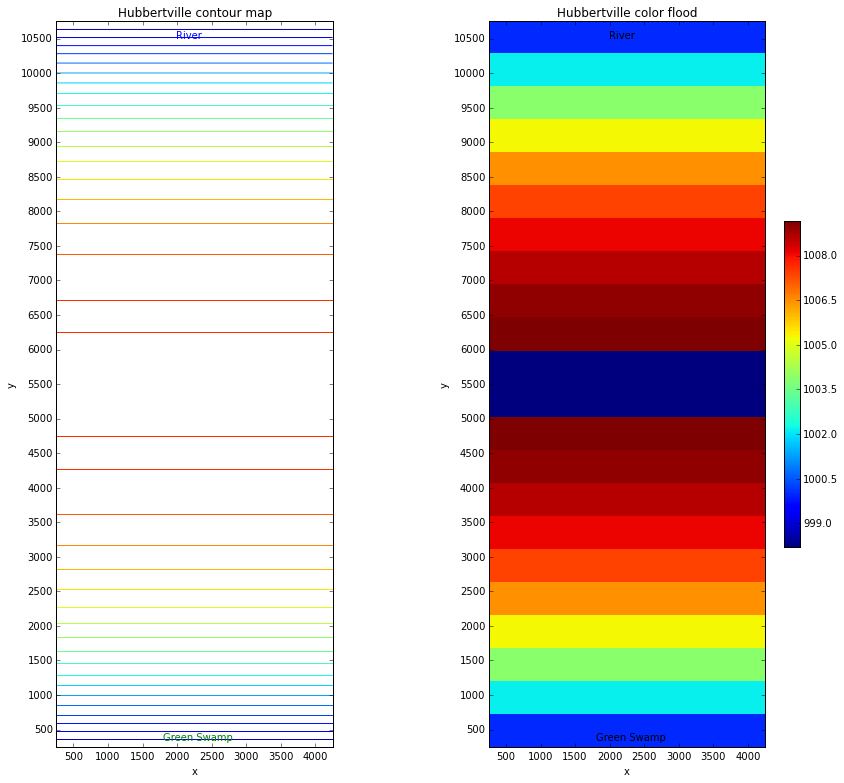

In [42]:
#-999.99 is the Inactive node flag so we'll use our previous contour settings
#Create a contour plot of heads
FIG = plt.figure(figsize=(15,13))

#setup contour levels and plot extent
LEVELS = np.arange(1000., 1011., 0.5)
EXTENT = (DELR/2., LX - DELR/2., DELC/2., LY - DELC/2.)
print 'Contour Levels: ', LEVELS
print 'Extent of domain: ', EXTENT

#Make a contour plot on the first axis
AX1 = FIG.add_subplot(1, 2, 1, aspect='equal')
AX1.set_xlabel("x")
AX1.set_ylabel("y")
YTICKS = np.arange(0, 11000, 500)
AX1.set_yticks(YTICKS)
AX1.set_title("Hubbertville contour map")
AX1.text(2000, 10500, r"River", fontsize=10, color="blue")
AX1.text(1800, 340, r"Green Swamp", fontsize=10, color="green")
AX1.contour(np.flipud(HEAD[0, :, :]), levels=LEVELS, extent=EXTENT)

#Make a color flood on the second axis
AX2 = FIG.add_subplot(1, 2, 2, aspect='equal')
AX2.set_xlabel("x")
AX2.set_ylabel("y")
AX2.set_yticks(YTICKS)
AX2.set_title("Hubbertville color flood")
AX2.text(2000, 10500, r"River", fontsize=10, color="black")
AX2.text(1800, 340, r"Green Swamp", fontsize=10, color="black")
cax = AX2.imshow(HEAD[0, :, :], extent=EXTENT, interpolation='nearest', vmin=998.2)
cbar = FIG.colorbar(cax, orientation='vertical', shrink=0.45)

In [43]:
COL = 4
# recall we need to flip because MODFLOW's array does not = Python, so we reverse the order (flip them) and call it 
Y = np.flipud(HEAD[0,:,COL])
print Y

[ 1000.          1002.14117432  1003.88195801  1005.30627441  1006.46575928
  1007.39434814  1008.1151123   1008.64367676  1008.99072266  1009.16265869
  -999.98999023  -999.98999023  1009.16265869  1008.99072266  1008.64367676
  1008.1151123   1007.39434814  1006.46575928  1005.30627441  1003.88195801
  1002.14123535  1000.        ]


In [44]:
#for our cross section create X-coordinates to match with heads
XCOORD = np.arange(0, 11000, 500) + 250
print XCOORD

[  250   750  1250  1750  2250  2750  3250  3750  4250  4750  5250  5750
  6250  6750  7250  7750  8250  8750  9250  9750 10250 10750]


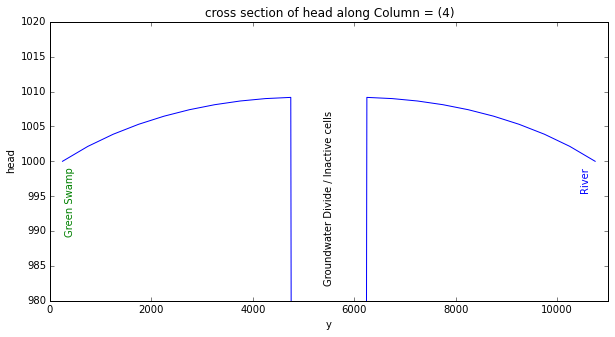

In [45]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)
TITLE =  'cross section of head along Column = ({0})'.format(COL)
ax.set_title(TITLE)
ax.set_xlabel('y')
ax.set_ylabel('head')
ax.set_xlim(0, 11000.)
ax.set_ylim(980.,1020.)
ax.text(10480, 998, r"River", fontsize=10, color="blue",rotation='vertical')
ax.text(300, 998, r"Green Swamp", fontsize=10, color="green",rotation='vertical')
ax.text(5400,1006., r"Groundwater Divide / Inactive cells", fontsize=10, color="black",rotation='vertical')
ax.plot(XCOORD, Y)

In [46]:
#calculate the flux to Green Swamp
HEAD_ADJACENT_CELLS = HEAD[0,-2,:]
print "heads in cells next to Green Swamp =", HEAD_ADJACENT_CELLS
FLUX_TO_SWAMP_NO_FLOW = 0
THICK = (HEAD[0,-2,5]+1000.)/2 - ZBOT   #the thickness is approximated using the average saturated thickness
for NODEHEAD in HEAD_ADJACENT_CELLS:
    NODEFLUX = (HK * (NODEHEAD-1000.)/(DELC) * DELR * THICK) # Q = KIA
    FLUX_TO_SWAMP_NO_FLOW += NODEFLUX
    print 'gradient =', (NODEHEAD-1000)/(DELC), '  Kh =', HK, '  thickness=', THICK, ' Grid spacing =', DELC, ' Node flux =', NODEFLUX
print "Total Flux to Swamp (No Flow) =", FLUX_TO_SWAMP_NO_FLOW, "cubic meters per day"

heads in cells next to Green Swamp = [ 1002.14117432  1002.14117432  1002.14117432  1002.14117432  1002.14117432
  1002.14117432  1002.14117432  1002.14117432  1002.14117432]
gradient = 0.00428234863281   Kh = 50.0   thickness= 21.0705871582  Grid spacing = 500.0  Node flux = 2255.79000274
gradient = 0.00428234863281   Kh = 50.0   thickness= 21.0705871582  Grid spacing = 500.0  Node flux = 2255.79000274
gradient = 0.00428234863281   Kh = 50.0   thickness= 21.0705871582  Grid spacing = 500.0  Node flux = 2255.79000274
gradient = 0.00428234863281   Kh = 50.0   thickness= 21.0705871582  Grid spacing = 500.0  Node flux = 2255.79000274
gradient = 0.00428234863281   Kh = 50.0   thickness= 21.0705871582  Grid spacing = 500.0  Node flux = 2255.79000274
gradient = 0.00428234863281   Kh = 50.0   thickness= 21.0705871582  Grid spacing = 500.0  Node flux = 2255.79000274
gradient = 0.00428234863281   Kh = 50.0   thickness= 21.0705871582  Grid spacing = 500.0  Node flux = 2255.79000274
gradient = 0.

Why is there less water in the system than when the gw divide was not simulated with no-flow cells?

Note that this problem is harder to solve.  To see non-convergence in MODFLOW, set the dampening in block In [36] to 1.0

###Now let's try a specified head for the groundwater divide

In [47]:
# Rows 10 and 11 had highest heads; reset Row 10 and 11 to a  specified head boundary (set that row to -1 in the MODFLOW IBOUND array)
IBOUND[:, 10, :] = -1 
IBOUND[:, 11, :] = -1 
print IBOUND

[[[-1 -1 -1 -1 -1 -1 -1 -1 -1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [-1 -1 -1 -1 -1 -1 -1 -1 -1]
  [-1 -1 -1 -1 -1 -1 -1 -1 -1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [-1 -1 -1 -1 -1 -1 -1 -1 -1]]]


In [48]:
#MODFLOW uses the starting heads to set the specified head boundary elevations
#we need to reset the starting heads in Rows 10 and 11 to what they were originally
#recall we saved these heads, and can print them to check
print "Row 10 heads =", ROW10_HEAD
print "Row 11 heads =", ROW11_HEAD

Row 10 heads = [ 1010.83233643  1010.83233643  1010.83233643  1010.83233643  1010.83233643
  1010.83233643  1010.83233643  1010.83233643  1010.83233643]
Row 11 heads = [ 1010.83233643  1010.83233643  1010.83233643  1010.83233643  1010.83233643
  1010.83233643  1010.83233643  1010.83233643  1010.83233643]


In [49]:
STRT[:, 10, :] = ROW10_HEAD       # setting starting heads Row 10 to heads calculated in Part a.
STRT[:, 11, :] = ROW11_HEAD       # setting starting heads Row 10 to heads calculated in Part a.
print STRT

[[[ 1000.          1000.          1000.          1000.          1000.
    1000.          1000.          1000.          1000.        ]
  [ 1015.          1015.          1015.          1015.          1015.
    1015.          1015.          1015.          1015.        ]
  [ 1015.          1015.          1015.          1015.          1015.
    1015.          1015.          1015.          1015.        ]
  [ 1015.          1015.          1015.          1015.          1015.
    1015.          1015.          1015.          1015.        ]
  [ 1015.          1015.          1015.          1015.          1015.
    1015.          1015.          1015.          1015.        ]
  [ 1015.          1015.          1015.          1015.          1015.
    1015.          1015.          1015.          1015.        ]
  [ 1015.          1015.          1015.          1015.          1015.
    1015.          1015.          1015.          1015.        ]
  [ 1015.          1015.          1015.          1015.        

In [50]:
#we have to update the MODFLOW's BAS Package with the new STRT heads 
BAS_PACKAGE = flopy.modflow.ModflowBas(MF, ibound=IBOUND, strt=STRT)

****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


In [51]:
#delete old files to prevent us from reading old results
modelfiles = os.listdir(modelpath)
for filename in modelfiles:
    f = os.path.join(modelpath, filename)
    if modelname in f:
        try:
            os.remove(f)
            print 'Deleted: ', filename
        except:
            print 'Unable to delete: ', filename

Deleted:  P4-3.bas
Deleted:  P4-3.cbc
Deleted:  P4-3.ddn
Deleted:  P4-3.dis
Deleted:  P4-3.hds
Deleted:  P4-3.list
Deleted:  P4-3.lpf
Deleted:  P4-3.nam
Deleted:  P4-3.oc
Deleted:  P4-3.pcg
Deleted:  P4-3.rch
Deleted:  P4-3.wel


In [52]:
#Now write the model input files
MF.write_input()
print "New MODFLOW input files = ", modelfiles
print "You can check the newly created files in", modelpath


New MODFLOW input files =  ['P4-3.bas', 'P4-3.cbc', 'P4-3.ddn', 'P4-3.dis', 'P4-3.hds', 'P4-3.list', 'P4-3.lpf', 'P4-3.nam', 'P4-3.oc', 'P4-3.pcg', 'P4-3.rch', 'P4-3.wel']
You can check the newly created files in /Users/rjhunt1/GitHub/Chapter_4_problems-1/P4-3_Hubbertville


In [53]:
#rerun MODFLOW-2005
silent = False  #Print model output to screen?
pause = False   #Require user to hit enter? Doesn't mean much in Ipython notebook
report = True   #Store the output from the model in buff
success, buff = MF.run_model(silent=silent, pause=pause, report=report)

FloPy is using the following executable to run the model: /Users/rjhunt1/GitHub/Chapter_4_problems-1/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.11.00 8/8/2013                        

 Using NAME file: P4-3.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2015/04/24 13:47:52

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2015/04/24 13:47:52
 Elapsed run time:  0.006 Seconds

  Normal termination of simulation


In [54]:
#As before, let's look at the results and compare to P4-3 Part a.
#imports for plotting and reading the MODFLOW binary output file
import matplotlib.pyplot as plt
import flopy.utils.binaryfile as bf

#Create the headfile object and grab the results for last time.
headfile = os.path.join(modelpath, modelname + '.hds')
headfileobj = bf.HeadFile(headfile)

#Get a list of times that are contained in the model
times = headfileobj.get_times()
print 'Headfile (' + modelname + '.hds' + ') contains the following list of times: ', times

#Get a numpy array of heads for totim = 1.0
#The get_data method will extract head data from the binary file.
HEAD = headfileobj.get_data(totim=1.0)

#Print statistics on the head
print 'Head statistics'
print '  min: ', HEAD.min()
print '  max: ', HEAD.max()
print '  std: ', HEAD.std()

Headfile (P4-3.hds) contains the following list of times:  [1.0]
Head statistics
  min:  1000.0
  max:  1010.83
  std:  3.46996


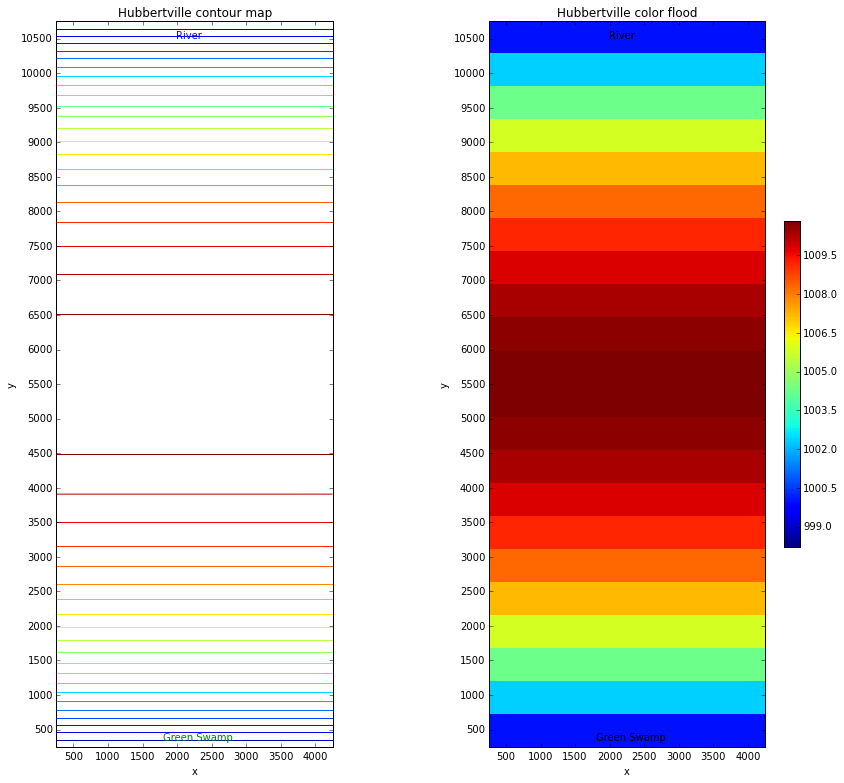

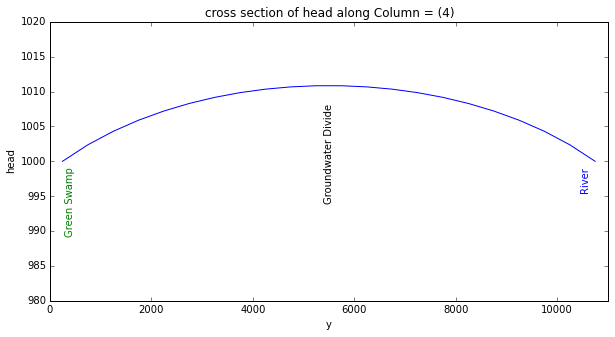

In [55]:
#Create a contour plot of heads
FIG = plt.figure(figsize=(15,13))

#setup contour levels and plot extent
LEVELS = np.arange(1000., 1011., 0.5)
EXTENT = (DELR/2., LX - DELR/2., DELC/2., LY - DELC/2.)

#Make a contour plot on the first axis
AX1 = FIG.add_subplot(1, 2, 1, aspect='equal')
AX1.set_xlabel("x")
AX1.set_ylabel("y")
YTICKS = np.arange(0, 11000, 500)
AX1.set_yticks(YTICKS)
AX1.set_title("Hubbertville contour map")
AX1.text(2000, 10500, r"River", fontsize=10, color="blue")
AX1.text(1800, 340, r"Green Swamp", fontsize=10, color="green")
AX1.contour(np.flipud(HEAD[0, :, :]), levels=LEVELS, extent=EXTENT)

#Make a color flood on the second axis
AX2 = FIG.add_subplot(1, 2, 2, aspect='equal')
AX2.set_xlabel("x")
AX2.set_ylabel("y")
AX2.set_yticks(YTICKS)
AX2.set_title("Hubbertville color flood")
AX2.text(2000, 10500, r"River", fontsize=10, color="black")
AX2.text(1800, 340, r"Green Swamp", fontsize=10, color="black")
cax = AX2.imshow(HEAD[0, :, :], extent=EXTENT, interpolation='nearest', vmin=998.2)
cbar = FIG.colorbar(cax, orientation='vertical', shrink=0.45)

#as before let's plot a north-south cross section
COL = 4
# recall we need to flip because MODFLOW's array does not = Python, so we reverse the order (flip them) and call it 
Y = np.flipud(HEAD[0,:,COL])
#for our cross section create X-coordinates to match with heads
XCOORD = np.arange(0, 11000, 500) + 250
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)
TITLE =  'cross section of head along Column = ({0})'.format(COL)
ax.set_title(TITLE)
ax.set_xlabel('y')
ax.set_ylabel('head')
ax.set_xlim(0, 11000.)
ax.set_ylim(980.,1020.)
ax.text(10480, 998, r"River", fontsize=10, color="blue",rotation='vertical')
ax.text(300, 998, r"Green Swamp", fontsize=10, color="green",rotation='vertical')
ax.text(5400,1007., r"Groundwater Divide", fontsize=10, color="black",rotation='vertical')
ax.plot(XCOORD, Y)

In [56]:
#calculate the flux to Green Swamp
HEAD_ADJACENT_CELLS = HEAD[0,-2,:]
print "heads in cells next to Green Swamp =", HEAD_ADJACENT_CELLS
FLUX_TO_SWAMP_SPEC_HEAD = 0
THICK = (HEAD[0,-2,5]+1000.)/2 - ZBOT   #the thickness is approximated using the average saturated thickness
for NODEHEAD in HEAD_ADJACENT_CELLS:
    NODEFLUX = (HK * (NODEHEAD-1000.)/(DELC) * DELR * THICK) # Q = KIA
    FLUX_TO_SWAMP_SPEC_HEAD += NODEFLUX
    print 'gradient =', (NODEHEAD-1000)/(DELC), '  Kh =', HK, '  thickness=', THICK, ' Grid spacing =', DELC, ' Node flux =', NODEFLUX
print "Total Flux to Swamp (Specified Head) =", FLUX_TO_SWAMP_SPEC_HEAD, "cubic meters per day"

heads in cells next to Green Swamp = [ 1002.36761475  1002.36761475  1002.36761475  1002.36761475  1002.36761475
  1002.36761475  1002.36761475  1002.36761475  1002.36761475]
gradient = 0.00473522949219   Kh = 50.0   thickness= 21.183807373  Grid spacing = 500.0  Node flux = 2507.75473574
gradient = 0.00473522949219   Kh = 50.0   thickness= 21.183807373  Grid spacing = 500.0  Node flux = 2507.75473574
gradient = 0.00473522949219   Kh = 50.0   thickness= 21.183807373  Grid spacing = 500.0  Node flux = 2507.75473574
gradient = 0.00473522949219   Kh = 50.0   thickness= 21.183807373  Grid spacing = 500.0  Node flux = 2507.75473574
gradient = 0.00473522949219   Kh = 50.0   thickness= 21.183807373  Grid spacing = 500.0  Node flux = 2507.75473574
gradient = 0.00473522949219   Kh = 50.0   thickness= 21.183807373  Grid spacing = 500.0  Node flux = 2507.75473574
gradient = 0.00473522949219   Kh = 50.0   thickness= 21.183807373  Grid spacing = 500.0  Node flux = 2507.75473574
gradient = 0.0047352

In [57]:
#let's compare the three formulations:  
#1) gw divide simulated; 2) gw divide as no flow BC; and 3) gw divide as specified head BC
print "Flux to Swamp (simulated) =", FLUX_TO_SWAMP
print "Flux to Swamp (no flow) = ", FLUX_TO_SWAMP_NO_FLOW
print "Flux to Swamp (spec head) = ", FLUX_TO_SWAMP_SPEC_HEAD

Flux to Swamp (simulated) = 22570.4069674
Flux to Swamp (no flow) =  20302.1100246
Flux to Swamp (spec head) =  22569.7926217


Why when the gw divide is simulated as a no-flow might the total flux to Green Swamp be different (and lower)?

#P4.3 Part c.

Run the model in part (a) again but this time use a HDB to represent the river. The stage of the river is 1000 m and the width is 500 m. The vertical hydraulic conductivity of the riverbed sediments is 5 m/day and the thickness of the sediments is 1 m. The elevation of the bottom of the sediments is 995 m. Compare results with those in part (a).

In [58]:
#We have to recreate the IBOUND and STRT heads of Part a. 
#This is just copied directly from Part a. above to start clean
# Variables for the BAS package
IBOUND = np.ones((NLAY, NROW, NCOL), dtype=np.int32)  # all nodes are active (IBOUND = 1)

# make the top of the profile specified head by setting the IBOUND = -1
IBOUND[:, 0, :] = -1  #don't forget arrays are zero-based!
IBOUND[:, -1, :] = -1  #-1 is Python for last in array
print IBOUND

[[[-1 -1 -1 -1 -1 -1 -1 -1 -1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [-1 -1 -1 -1 -1 -1 -1 -1 -1]]]


In [59]:
#BUT in Part c. the river to the north is a head-dependent BCs, not specified head
#so we have to change it from -1 (specified head) to 1 (active cells)
IBOUND[:, 0, :] = 1  #don't forget arrays are zero-based!
print IBOUND

[[[ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [ 1  1  1  1  1  1  1  1  1]
  [-1 -1 -1 -1 -1 -1 -1 -1 -1]]]


In [60]:
#In the same way, we need to reset the Starting Head array, but only need 
# values set for the specified head boundary used for Green Swamp in the south
STRT = 1015 * np.ones((NLAY, NROW, NCOL), dtype=np.float32)  # set starting head to 1010 m through out model domain
STRT[:, -1, :] = 1000.     # wetland stage for setting constant head
print STRT

[[[ 1015.  1015.  1015.  1015.  1015.  1015.  1015.  1015.  1015.]
  [ 1015.  1015.  1015.  1015.  1015.  1015.  1015.  1015.  1015.]
  [ 1015.  1015.  1015.  1015.  1015.  1015.  1015.  1015.  1015.]
  [ 1015.  1015.  1015.  1015.  1015.  1015.  1015.  1015.  1015.]
  [ 1015.  1015.  1015.  1015.  1015.  1015.  1015.  1015.  1015.]
  [ 1015.  1015.  1015.  1015.  1015.  1015.  1015.  1015.  1015.]
  [ 1015.  1015.  1015.  1015.  1015.  1015.  1015.  1015.  1015.]
  [ 1015.  1015.  1015.  1015.  1015.  1015.  1015.  1015.  1015.]
  [ 1015.  1015.  1015.  1015.  1015.  1015.  1015.  1015.  1015.]
  [ 1015.  1015.  1015.  1015.  1015.  1015.  1015.  1015.  1015.]
  [ 1015.  1015.  1015.  1015.  1015.  1015.  1015.  1015.  1015.]
  [ 1015.  1015.  1015.  1015.  1015.  1015.  1015.  1015.  1015.]
  [ 1015.  1015.  1015.  1015.  1015.  1015.  1015.  1015.  1015.]
  [ 1015.  1015.  1015.  1015.  1015.  1015.  1015.  1015.  1015.]
  [ 1015.  1015.  1015.  1015.  1015.  1015.  1015.  1015.  10

In [61]:
#we have to update the MODFLOW's BAS Package with the new IBOUND and STRT heads 
BAS_PACKAGE = flopy.modflow.ModflowBas(MF, ibound=IBOUND, strt=STRT)

****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


In [62]:
#now we need to add a HDB - the RIV Package is a good choice
#recall that a RIV node has a river stage, a conductance, and a bottom elevation
RIV_STAGE = 1000.
Kv_RIVER = 5.
b_RIVER = 1.
WIDTH_RIVER = 500.
SED_BOT_RIVER = 995.
# conductance = leakance x cross-sectional area
# leakance = Kv/b
RIV_LEAKANCE = Kv_RIVER / b_RIVER
print "River sediment leakance =", RIV_LEAKANCE


River sediment leakance = 5.0


In [63]:
#area is the nodal area, DELR x DELC which was entered above
print "DELR = ", DELR
print "River width =", WIDTH_RIVER
print "River area in node =", DELR * WIDTH_RIVER

DELR =  500.0
River width = 500.0
River area in node = 250000.0


In [64]:
#conductance is leakance x area
RIV_COND = RIV_LEAKANCE * DELR * WIDTH_RIVER
print 'River Conductance =', RIV_COND

River Conductance = 1250000.0


In [65]:
#We enter RIV Package data by "layer-row-column-data" = lrcd
stress_period_data = [
                      [0, 0, 0, RIV_STAGE, RIV_COND, SED_BOT_RIVER],   #layer, row, column, stage conductance, river bottom
                      [0, 0, 1, RIV_STAGE, RIV_COND, SED_BOT_RIVER],   #remember Python indexing is zero based
                      [0, 0, 2, RIV_STAGE, RIV_COND, SED_BOT_RIVER],
                      [0, 0, 3, RIV_STAGE, RIV_COND, SED_BOT_RIVER],
                      [0, 0, 4, RIV_STAGE, RIV_COND, SED_BOT_RIVER],
                      [0, 0, 5, RIV_STAGE, RIV_COND, SED_BOT_RIVER],
                      [0, 0, 6, RIV_STAGE, RIV_COND, SED_BOT_RIVER],
                      [0, 0, 7, RIV_STAGE, RIV_COND, SED_BOT_RIVER], 
                      [0, 0, 8, RIV_STAGE, RIV_COND, SED_BOT_RIVER]]



print stress_period_data

[[0, 0, 0, 1000.0, 1250000.0, 995.0], [0, 0, 1, 1000.0, 1250000.0, 995.0], [0, 0, 2, 1000.0, 1250000.0, 995.0], [0, 0, 3, 1000.0, 1250000.0, 995.0], [0, 0, 4, 1000.0, 1250000.0, 995.0], [0, 0, 5, 1000.0, 1250000.0, 995.0], [0, 0, 6, 1000.0, 1250000.0, 995.0], [0, 0, 7, 1000.0, 1250000.0, 995.0], [0, 0, 8, 1000.0, 1250000.0, 995.0]]


In [66]:
riv = flopy.modflow.ModflowRiv(MF, stress_period_data=stress_period_data)

In [67]:
#delete old files to prevent us from reading old results
modelfiles = os.listdir(modelpath)
for filename in modelfiles:
    f = os.path.join(modelpath, filename)
    if modelname in f:
        try:
            os.remove(f)
            print 'Deleted: ', filename
        except:
            print 'Unable to delete: ', filename

Deleted:  P4-3.bas
Deleted:  P4-3.cbc
Deleted:  P4-3.ddn
Deleted:  P4-3.dis
Deleted:  P4-3.hds
Deleted:  P4-3.list
Deleted:  P4-3.lpf
Deleted:  P4-3.nam
Deleted:  P4-3.oc
Deleted:  P4-3.pcg
Deleted:  P4-3.rch
Deleted:  P4-3.wel


In [68]:
#Now write the model input files
MF.write_input()
print "New MODFLOW input files = ", modelfiles
print "You can check the newly created files in", modelpath


New MODFLOW input files =  ['P4-3.bas', 'P4-3.cbc', 'P4-3.ddn', 'P4-3.dis', 'P4-3.hds', 'P4-3.list', 'P4-3.lpf', 'P4-3.nam', 'P4-3.oc', 'P4-3.pcg', 'P4-3.rch', 'P4-3.wel']
You can check the newly created files in /Users/rjhunt1/GitHub/Chapter_4_problems-1/P4-3_Hubbertville


In [69]:
#rerun MODFLOW-2005
silent = False  #Print model output to screen?
pause = False   #Require user to hit enter? Doesn't mean much in Ipython notebook
report = True   #Store the output from the model in buff
success, buff = MF.run_model(silent=silent, pause=pause, report=report)


FloPy is using the following executable to run the model: /Users/rjhunt1/GitHub/Chapter_4_problems-1/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.11.00 8/8/2013                        

 Using NAME file: P4-3.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2015/04/24 13:47:54

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2015/04/24 13:47:54
 Elapsed run time:  0.007 Seconds

  Normal termination of simulation


Headfile (P4-3.hds) contains the following list of times:  [1.0]


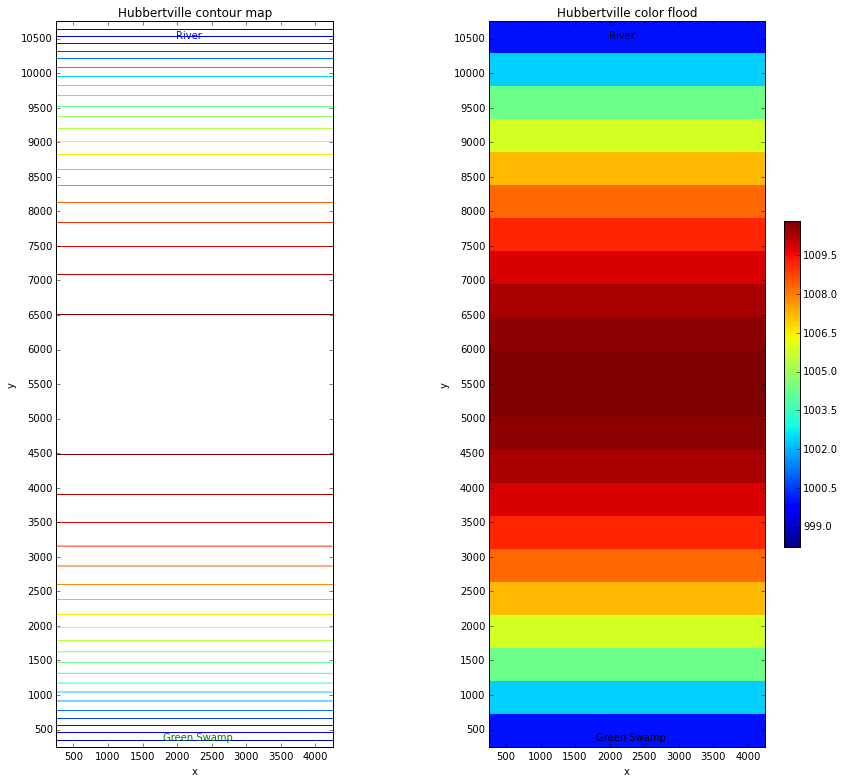

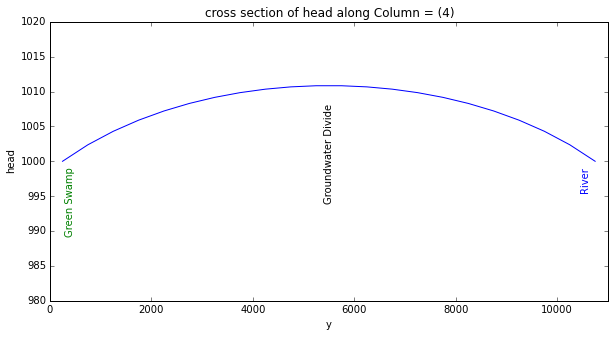

In [70]:
#As before, let's look at the results and compare to P4-3 Part a.
#imports for plotting and reading the MODFLOW binary output file
import matplotlib.pyplot as plt
import flopy.utils.binaryfile as bf

#Create the headfile object and grab the results for last time.
headfile = os.path.join(modelpath, modelname + '.hds')
headfileobj = bf.HeadFile(headfile)

#Get a list of times that are contained in the model
times = headfileobj.get_times()
print 'Headfile (' + modelname + '.hds' + ') contains the following list of times: ', times

#Get a numpy array of heads for totim = 1.0
#The get_data method will extract head data from the binary file.
HEAD = headfileobj.get_data(totim=1.0)

#Create a contour plot of heads
FIG = plt.figure(figsize=(15,13))

#setup contour levels and plot extent
LEVELS = np.arange(1000., 1011., 0.5)
EXTENT = (DELR/2., LX - DELR/2., DELC/2., LY - DELC/2.)

#Make a contour plot on the first axis
AX1 = FIG.add_subplot(1, 2, 1, aspect='equal')
AX1.set_xlabel("x")
AX1.set_ylabel("y")
YTICKS = np.arange(0, 11000, 500)
AX1.set_yticks(YTICKS)
AX1.set_title("Hubbertville contour map")
AX1.text(2000, 10500, r"River", fontsize=10, color="blue")
AX1.text(1800, 340, r"Green Swamp", fontsize=10, color="green")
AX1.contour(np.flipud(HEAD[0, :, :]), levels=LEVELS, extent=EXTENT)

#Make a color flood on the second axis
AX2 = FIG.add_subplot(1, 2, 2, aspect='equal')
AX2.set_xlabel("x")
AX2.set_ylabel("y")
AX2.set_yticks(YTICKS)
AX2.set_title("Hubbertville color flood")
AX2.text(2000, 10500, r"River", fontsize=10, color="black")
AX2.text(1800, 340, r"Green Swamp", fontsize=10, color="black")
cax = AX2.imshow(HEAD[0, :, :], extent=EXTENT, interpolation='nearest', vmin=998.2)
cbar = FIG.colorbar(cax, orientation='vertical', shrink=0.45)

#as before let's plot a north-south cross section
COL = 4
# recall we need to flip because MODFLOW's array does not = Python, so we reverse the order (flip them) and call it 
Y = np.flipud(HEAD[0,:,COL])
#for our cross section create X-coordinates to match with heads
XCOORD = np.arange(0, 11000, 500) + 250
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)
TITLE =  'cross section of head along Column = ({0})'.format(COL)
ax.set_title(TITLE)
ax.set_xlabel('y')
ax.set_ylabel('head')
ax.set_xlim(0, 11000.)
ax.set_ylim(980.,1020.)
ax.text(10480, 998, r"River", fontsize=10, color="blue",rotation='vertical')
ax.text(300, 998, r"Green Swamp", fontsize=10, color="green",rotation='vertical')
ax.text(5400,1007., r"Groundwater Divide", fontsize=10, color="black",rotation='vertical')
ax.plot(XCOORD, Y)

In [71]:
#Print statistics on the head
print 'Head statistics'
print '  min: ', HEAD.min()
print '  max: ', HEAD.max()
print '  std: ', HEAD.std()

Head statistics
  min:  1000.0
  max:  1010.83
  std:  3.46995


#P4.3 Part d.
Run the model in part (c) again but this time assume the width of the river is 5 m. What is the effect of reducing the width of the river?

In [72]:
WIDTH_RIVER = 5.
#area is the nodal area, DELR x DELC which was entered above
print "DELR = ", DELR
print "River width =", WIDTH_RIVER
print "River area in node =", DELR * WIDTH_RIVER
#conductance is leakance x area
print 'River Leakance = ', RIV_LEAKANCE
RIV_COND = RIV_LEAKANCE * DELR * WIDTH_RIVER
print 'River Conductance =', RIV_COND

DELR =  500.0
River width = 5.0
River area in node = 2500.0
River Leakance =  5.0
River Conductance = 12500.0


In [73]:
#We enter RIV Package data by "layer-row-column-data" = lrcd
stress_period_data = [
                      [0, 0, 0, RIV_STAGE, RIV_COND, SED_BOT_RIVER],   #layer, row, column, stage conductance, river bottom
                      [0, 0, 1, RIV_STAGE, RIV_COND, SED_BOT_RIVER],   #remember Python indexing is zero based
                      [0, 0, 2, RIV_STAGE, RIV_COND, SED_BOT_RIVER],
                      [0, 0, 3, RIV_STAGE, RIV_COND, SED_BOT_RIVER],
                      [0, 0, 4, RIV_STAGE, RIV_COND, SED_BOT_RIVER],
                      [0, 0, 5, RIV_STAGE, RIV_COND, SED_BOT_RIVER],
                      [0, 0, 6, RIV_STAGE, RIV_COND, SED_BOT_RIVER],
                      [0, 0, 7, RIV_STAGE, RIV_COND, SED_BOT_RIVER], 
                      [0, 0, 8, RIV_STAGE, RIV_COND, SED_BOT_RIVER]]



print stress_period_data

[[0, 0, 0, 1000.0, 12500.0, 995.0], [0, 0, 1, 1000.0, 12500.0, 995.0], [0, 0, 2, 1000.0, 12500.0, 995.0], [0, 0, 3, 1000.0, 12500.0, 995.0], [0, 0, 4, 1000.0, 12500.0, 995.0], [0, 0, 5, 1000.0, 12500.0, 995.0], [0, 0, 6, 1000.0, 12500.0, 995.0], [0, 0, 7, 1000.0, 12500.0, 995.0], [0, 0, 8, 1000.0, 12500.0, 995.0]]


In [74]:
riv = flopy.modflow.ModflowRiv(MF, stress_period_data=stress_period_data)
#delete old files to prevent us from reading old results
modelfiles = os.listdir(modelpath)
for filename in modelfiles:
    f = os.path.join(modelpath, filename)
    if modelname in f:
        try:
            os.remove(f)
            print 'Deleted: ', filename
        except:
            print 'Unable to delete: ', filename
            

****Warning -- two packages of the same type:  <class 'flopy.modflow.mfriv.ModflowRiv'> <class 'flopy.modflow.mfriv.ModflowRiv'>
replacing existing Package...
Deleted:  P4-3.bas
Deleted:  P4-3.cbc
Deleted:  P4-3.ddn
Deleted:  P4-3.dis
Deleted:  P4-3.hds
Deleted:  P4-3.list
Deleted:  P4-3.lpf
Deleted:  P4-3.nam
Deleted:  P4-3.oc
Deleted:  P4-3.pcg
Deleted:  P4-3.rch
Deleted:  P4-3.riv
Deleted:  P4-3.wel


In [75]:
#Now write the model input files and rerun MODFLOW
MF.write_input()
print "New MODFLOW input files = ", modelfiles
print "You can check the newly created files in", modelpath
#rerun MODFLOW-2005
silent = False  #Print model output to screen?
pause = False   #Require user to hit enter? Doesn't mean much in Ipython notebook
report = True   #Store the output from the model in buff
success, buff = MF.run_model(silent=silent, pause=pause, report=report)


New MODFLOW input files =  ['P4-3.bas', 'P4-3.cbc', 'P4-3.ddn', 'P4-3.dis', 'P4-3.hds', 'P4-3.list', 'P4-3.lpf', 'P4-3.nam', 'P4-3.oc', 'P4-3.pcg', 'P4-3.rch', 'P4-3.riv', 'P4-3.wel']
You can check the newly created files in /Users/rjhunt1/GitHub/Chapter_4_problems-1/P4-3_Hubbertville
FloPy is using the following executable to run the model: /Users/rjhunt1/GitHub/Chapter_4_problems-1/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.11.00 8/8/2013                        

 Using NAME file: P4-3.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2015/04/24 13:47:56

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2015/04/24 13:47:56
 Elapsed run time:  0.007 Seconds

  Normal termination of simulation


Headfile (P4-3.hds) contains the following list of times:  [1.0]


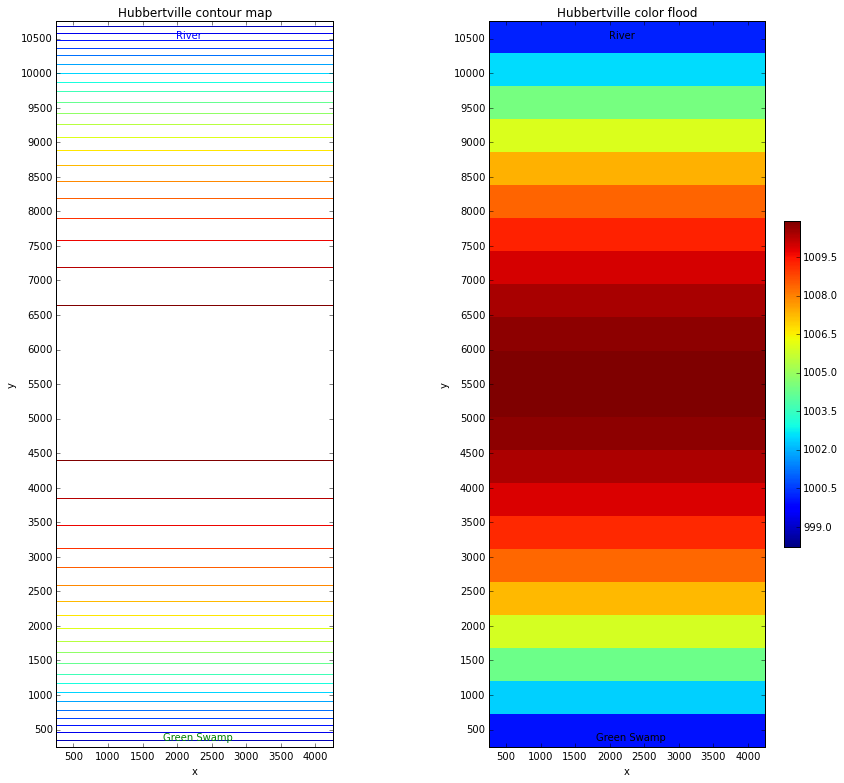

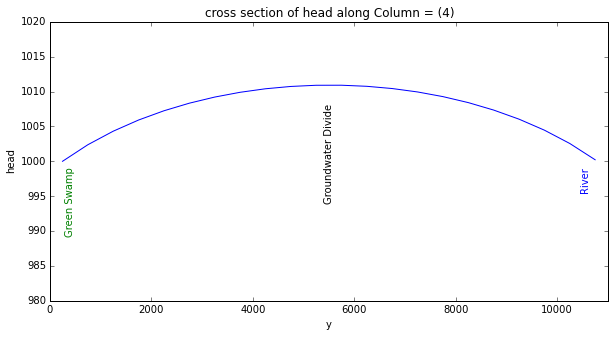

In [76]:
#As before, let's look at the results and compare to P4-3 Part a.
#imports for plotting and reading the MODFLOW binary output file
import matplotlib.pyplot as plt
import flopy.utils.binaryfile as bf

#Create the headfile object and grab the results for last time.
headfile = os.path.join(modelpath, modelname + '.hds')
headfileobj = bf.HeadFile(headfile)

#Get a list of times that are contained in the model
times = headfileobj.get_times()
print 'Headfile (' + modelname + '.hds' + ') contains the following list of times: ', times

#Get a numpy array of heads for totim = 1.0
#The get_data method will extract head data from the binary file.
HEAD = headfileobj.get_data(totim=1.0)

#Create a contour plot of heads
FIG = plt.figure(figsize=(15,13))

#setup contour levels and plot extent
LEVELS = np.arange(1000., 1011., 0.5)
EXTENT = (DELR/2., LX - DELR/2., DELC/2., LY - DELC/2.)

#Make a contour plot on the first axis
AX1 = FIG.add_subplot(1, 2, 1, aspect='equal')
AX1.set_xlabel("x")
AX1.set_ylabel("y")
YTICKS = np.arange(0, 11000, 500)
AX1.set_yticks(YTICKS)
AX1.set_title("Hubbertville contour map")
AX1.text(2000, 10500, r"River", fontsize=10, color="blue")
AX1.text(1800, 340, r"Green Swamp", fontsize=10, color="green")
AX1.contour(np.flipud(HEAD[0, :, :]), levels=LEVELS, extent=EXTENT)

#Make a color flood on the second axis
AX2 = FIG.add_subplot(1, 2, 2, aspect='equal')
AX2.set_xlabel("x")
AX2.set_ylabel("y")
AX2.set_yticks(YTICKS)
AX2.set_title("Hubbertville color flood")
AX2.text(2000, 10500, r"River", fontsize=10, color="black")
AX2.text(1800, 340, r"Green Swamp", fontsize=10, color="black")
cax = AX2.imshow(HEAD[0, :, :], extent=EXTENT, interpolation='nearest', vmin=998.2)
cbar = FIG.colorbar(cax, orientation='vertical', shrink=0.45)

#as before let's plot a north-south cross section
COL = 4
# recall we need to flip because MODFLOW's array does not = Python, so we reverse the order (flip them) and call it 
Y = np.flipud(HEAD[0,:,COL])
#for our cross section create X-coordinates to match with heads
XCOORD = np.arange(0, 11000, 500) + 250
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)
TITLE =  'cross section of head along Column = ({0})'.format(COL)
ax.set_title(TITLE)
ax.set_xlabel('y')
ax.set_ylabel('head')
ax.set_xlim(0, 11000.)
ax.set_ylim(980.,1020.)
ax.text(10480, 998, r"River", fontsize=10, color="blue",rotation='vertical')
ax.text(300, 998, r"Green Swamp", fontsize=10, color="green",rotation='vertical')
ax.text(5400,1007., r"Groundwater Divide", fontsize=10, color="black",rotation='vertical')
ax.plot(XCOORD, Y)

In [77]:
#Print statistics on the head
print 'Head statistics'
print '  min: ', HEAD.min()
print '  max: ', HEAD.max()
print '  std: ', HEAD.std()

Head statistics
  min:  1000.0
  max:  1010.91
  std:  3.45877


How different are the results from the two river widths?  Why might this be?